### Input

In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import helpfunction as helper
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import pickle

pd.set_option("display.max_columns", 500)

<IPython.core.display.Javascript object>

In [3]:
%autoreload

<IPython.core.display.Javascript object>

### Constants

In [4]:
run = 1
run_str = "run" + str(run)

<IPython.core.display.Javascript object>

In [5]:
pot_target = 4.3e20  # Run1+Run3
lee_focus = 1

<IPython.core.display.Javascript object>

In [6]:
x_sce_magic = 1.03
pid_upper_clip = 300

<IPython.core.display.Javascript object>

In [7]:
max_trk_score = 0.4
min_cluster_frac = 0.6
min_shw_e = 75  # MeV
max_cosmic_impact = 15
min_topo_score = 0.15

<IPython.core.display.Javascript object>

In [8]:
retrain = True
train_run1 = {
    "run1": ["ccpi0", "elee_high", "elee_low", "ncpi0"],
    "run3": ["elee_high", "elee_low", "nu", "nue", "ncpi0"],
}
train_run3 = {
    "run1": ["ccpi0", "elee_high", "elee_low", "ncpi0", "nue", "nu"],
    "run3": ["elee_high", "elee_low", "ncpi0"],
}
plot_samples = ["nu", "nue", "on", "off", "dirt"]
train_samples = {"run1": train_run1, "run3": train_run3}
seed = 7
test_size = 0.25

<IPython.core.display.Javascript object>

### Load Samples

In [9]:
input_dir = "./input/23Nov/".format(run)
output_dir = "./output/run{}/".format(run)
model_dir = "./models/run{}/".format(run)

<IPython.core.display.Javascript object>

In [10]:
%%time
data_run1 = pickle.load(open(input_dir+"run1_slimmed.pckl".format(run), 'rb'))
data_run3 = pickle.load(open(input_dir+"run3_slimmed.pckl".format(run), 'rb'))
data_samples = {
    "run1": data_run1,
    "run3": data_run3,
}

CPU times: user 941 ms, sys: 1.65 s, total: 2.59 s
Wall time: 4.64 s


<IPython.core.display.Javascript object>

In [11]:
sample_info = {}
for s in plot_samples:
    sample_info[s] = data_samples[run_str][s]

# Prepare training data set
if retrain:
    sample_info["train"] = {}
    daughter_df_list = []
    train_names = []
    num_entries = 0
    for run_i in train_samples[run_str]:
        for sample_i in train_samples[run_str][run_i]:
            daughter_df_list.append(data_samples[run_i][sample_i]["daughters"])
            num_entries += data_samples[run_i][sample_i]["numentries"]
            train_names.append(run_i + "_" + sample_i)
    sample_info["train"]["daughters"] = pd.concat(
        daughter_df_list,
        sort=False,
        copy=False,
        verify_integrity=True,
        keys=train_names,
    )
    sample_info["train"]["daughters"].index.names = ["sample", "event", "daughter"]
    sample_info["train"]["numentries"] = num_entries
    print("Training set constructed with {} entries.".format(num_entries))

data_samples.clear()

Training set constructed with 1374395 entries.


<IPython.core.display.Javascript object>

In [12]:
sample_info["train"]["daughters"]["_closestNuCosmicDist"]

sample      event  daughter
run1_ccpi0  0      0                  NaN
            2      0                  NaN
                   1                  NaN
                   2                  NaN
                   3                  NaN
                                  ...    
run3_ncpi0  88730  3            95.055022
            88731  0           149.410760
            88732  0            67.683225
            88733  0            46.134855
                   1            46.134855
Name: _closestNuCosmicDist, Length: 1968595, dtype: float64

<IPython.core.display.Javascript object>

In [13]:
pot_scale = pot_target / sample_info["on"]["pot"]

<IPython.core.display.Javascript object>

### Explore Tree

In [14]:
fields = sample_info["nue"]["fields"]
shr_fields = [f for f in fields if f.startswith("shr_") and f.endswith("_v")]
trk_fields = [f for f in fields if f.startswith("trk_") and f.endswith("_v")]
backracked_fields = [f for f in fields if f.startswith("backtracked_")]
mc_fields = [f for f in fields if f.startswith(("true_", "mc_"))]
other_fields = (
    set(fields)
    - set(shr_fields)
    - set(trk_fields)
    - set(backracked_fields)
    - set(mc_fields)
)

<IPython.core.display.Javascript object>

In [15]:
trk_fields

['trk_score_v',
 'trk_bragg_p_v',
 'trk_bragg_mu_v',
 'trk_bragg_mip_v',
 'trk_pida_v',
 'trk_pid_chipr_v',
 'trk_pid_chipi_v',
 'trk_pid_chika_v',
 'trk_pid_chimu_v',
 'trk_bragg_p_u_v',
 'trk_bragg_mu_u_v',
 'trk_bragg_mip_u_v',
 'trk_pida_u_v',
 'trk_pid_chipr_u_v',
 'trk_pid_chipi_u_v',
 'trk_pid_chika_u_v',
 'trk_pid_chimu_u_v',
 'trk_bragg_p_v_v',
 'trk_bragg_mu_v_v',
 'trk_bragg_mip_v_v',
 'trk_pida_v_v',
 'trk_pid_chipr_v_v',
 'trk_pid_chipi_v_v',
 'trk_pid_chika_v_v',
 'trk_pid_chimu_v_v',
 'trk_pfp_id_v',
 'trk_dir_x_v',
 'trk_dir_y_v',
 'trk_dir_z_v',
 'trk_start_x_v',
 'trk_start_y_v',
 'trk_start_z_v',
 'trk_sce_start_x_v',
 'trk_sce_start_y_v',
 'trk_sce_start_z_v',
 'trk_end_x_v',
 'trk_end_y_v',
 'trk_end_z_v',
 'trk_sce_end_x_v',
 'trk_sce_end_y_v',
 'trk_sce_end_z_v',
 'trk_distance_v',
 'trk_theta_v',
 'trk_phi_v',
 'trk_len_v',
 'trk_mcs_muon_mom_v',
 'trk_energy_proton_v',
 'trk_energy_muon_v',
 'trk_calo_energy_u_v',
 'trk_calo_energy_v_v',
 'trk_calo_energy_y_v',

<IPython.core.display.Javascript object>

In [16]:
shr_fields

['shr_dedx_u_v',
 'shr_dedx_v_v',
 'shr_dedx_y_v',
 'shr_energy_u_v',
 'shr_energy_v_v',
 'shr_energy_y_v',
 'shr_pfp_id_v',
 'shr_start_x_v',
 'shr_start_y_v',
 'shr_start_z_v',
 'shr_start_U_v',
 'shr_start_V_v',
 'shr_px_v',
 'shr_py_v',
 'shr_pz_v',
 'shr_openangle_v',
 'shr_theta_v',
 'shr_phi_v',
 'shr_pitch_u_v',
 'shr_pitch_v_v',
 'shr_pitch_y_v',
 'shr_tkfit_nhits_v',
 'shr_tkfit_start_x_v',
 'shr_tkfit_start_y_v',
 'shr_tkfit_start_z_v',
 'shr_tkfit_start_U_v',
 'shr_tkfit_start_V_v',
 'shr_tkfit_theta_v',
 'shr_tkfit_phi_v',
 'shr_tkfit_pitch_u_v',
 'shr_tkfit_pitch_v_v',
 'shr_tkfit_pitch_y_v',
 'shr_tkfit_dedx_u_v',
 'shr_tkfit_dedx_v_v',
 'shr_tkfit_dedx_y_v',
 'shr_tkfit_gap10_dedx_u_v',
 'shr_tkfit_gap10_dedx_v_v',
 'shr_tkfit_gap10_dedx_y_v',
 'shr_tkfit_dedx_nhits_u_v',
 'shr_tkfit_dedx_nhits_v_v',
 'shr_tkfit_dedx_nhits_y_v',
 'shr_moliere_avg_v',
 'shr_moliere_rms_v',
 'shr_spacepoint_start_x_v',
 'shr_spacepoint_start_y_v',
 'shr_spacepoint_start_z_v',
 'shr_spacep

<IPython.core.display.Javascript object>

In [17]:
backracked_fields

['backtracked_pdg',
 'backtracked_e',
 'backtracked_purity',
 'backtracked_completeness',
 'backtracked_overlay_purity',
 'backtracked_px',
 'backtracked_py',
 'backtracked_pz',
 'backtracked_start_x',
 'backtracked_start_y',
 'backtracked_start_z',
 'backtracked_start_t',
 'backtracked_start_U',
 'backtracked_start_V',
 'backtracked_start_Y',
 'backtracked_sce_start_x',
 'backtracked_sce_start_y',
 'backtracked_sce_start_z',
 'backtracked_sce_start_U',
 'backtracked_sce_start_V',
 'backtracked_sce_start_Y']

<IPython.core.display.Javascript object>

In [18]:
other_fields

{'CosmicDirAll2DEnds',
 'CosmicDirAll2DOvlp',
 'CosmicDirAll3D',
 'CosmicIP',
 'CosmicIPAll2DEnds',
 'CosmicIPAll2DOvlp',
 'CosmicIPAll3D',
 'NeutrinoEnergy0',
 'NeutrinoEnergy1',
 'NeutrinoEnergy2',
 'SliceCaloEnergy0',
 'SliceCaloEnergy1',
 'SliceCaloEnergy2',
 'bdt_cosmic',
 'bdt_ext',
 'bdt_global',
 'bdt_nuNCpi0',
 'bdt_numuCC',
 'bdt_numuCCpi0',
 'best_cosmic_flashmatch_score',
 'best_obviouscosmic_flashmatch_score',
 'category',
 'ccnc',
 'contained_fraction',
 'contained_sps_ratio',
 'cosmic_flashmatch_score_v',
 'crthitpe',
 'crtveto',
 'dmc_boundary',
 'dshr_boundary',
 'dshr_x_boundary',
 'dshr_y_boundary',
 'dshr_z_boundary',
 'dtrk',
 'dtrk_boundary',
 'dtrk_x_boundary',
 'dtrk_y_boundary',
 'dtrk_z_boundary',
 'dvtx',
 'dvtx_boundary',
 'dvtx_x_boundary',
 'dvtx_y_boundary',
 'dvtx_z_boundary',
 'elec_c',
 'elec_dist',
 'elec_e',
 'elec_edep',
 'elec_etot',
 'elec_p',
 'elec_parent',
 'elec_vx',
 'elec_vy',
 'elec_vz',
 'endmuonmichel',
 'endmuonprocess',
 'evgamnhits',
 

<IPython.core.display.Javascript object>

In [19]:
# search through fields:
[f for f in fields if "dau" in f]

['pfp_trk_daughters_v', 'pfp_shr_daughters_v']

<IPython.core.display.Javascript object>

In [20]:
sample_info["on"]["daughters"].keys()

Index(['run', 'sub', 'evt', 'topological_score', 'n_pfps', 'n_showers',
       'n_tracks', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_y',
       'reco_nu_vtx_sce_z', 'reco_nu_vtx_x', 'reco_nu_vtx_y', 'reco_nu_vtx_z',
       'crtveto', 'crthitpe', 'slclustfrac', 'hits_ratio',
       'nu_flashmatch_score', 'selected', 'category', 'nslice', 'CosmicIP',
       'n_tracks_contained', 'contained_sps_ratio', 'contained_fraction',
       'slpdg', 'SliceCaloEnergy2', 'NeutrinoEnergy2', 'trk_score_v',
       'trk_distance_v', 'trk_theta_v', 'trk_phi_v', 'trk_len_v',
       'trk_pid_chipr_v', 'trk_pid_chimu_v', 'trk_pid_chipr_v_v',
       'trk_pid_chimu_v_v', 'trk_pid_chipr_u_v', 'trk_pid_chimu_u_v',
       'trk_llr_pid_u_v', 'trk_llr_pid_v_v', 'trk_llr_pid_y_v',
       'trk_llr_pid_v', 'trk_llr_pid_score_v', 'trk_mcs_muon_mom_v',
       'trk_calo_energy_y_v', 'trk_sce_end_x_v', 'trk_sce_end_y_v',
       'trk_sce_end_z_v', 'trk_sce_start_x_v', 'trk_sce_start_y_v',
       'trk_sce_start_z_v', 'shr_energ

<IPython.core.display.Javascript object>

### Add fields

In [21]:
%%time
# For all samples
for k, v in sample_info.items():
    print(k)
    grouper='event'
    if k=='train':
        grouper=['event','sample']
    # Add fiducial reco sce vtx
    v["daughters"]["reco_fid_vol"] = np.repeat(
       helper.is_fid(
           *v["daughters"][
               ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
           ]
           .xs(0, level="daughter")
           .values.T
       ),
       v["daughters"]["n_pfps"].xs(0, level="daughter"),
    )
    end_mask = helper.is_contain(
        v["daughters"]["trk_sce_end_x_v"],
        v["daughters"]["trk_sce_end_y_v"],
        v["daughters"]["trk_sce_end_z_v"],
    )
    start_mask = helper.is_contain(
        v["daughters"]["trk_sce_start_x_v"],
        v["daughters"]["trk_sce_start_y_v"],
        v["daughters"]["trk_sce_start_z_v"],
    )
    v["daughters"]["all_start_contained"] = start_mask
    v["daughters"]["all_start_contained"] = (
        v["daughters"]["all_start_contained"].groupby("event").transform(min)
    )
    v["daughters"]["all_end_contained"] = end_mask
    v["daughters"]["all_end_contained"] = (
        v["daughters"]["all_end_contained"].groupby("event").transform(min)
    )
    # Add pfp at vtx:
    v["daughters"]["n_pfpvtx"] = v["daughters"].eval("trk_distance_v<3 & trk_distance_v>=0")
    v["daughters"]["n_pfpvtx"] = v["daughters"]['n_pfpvtx'].groupby(grouper, sort=False).transform(sum)
    v["daughters"]["n_pfp_farvtx"] = v["daughters"].eval("n_pfps-n_pfpvtx")
    # Add shower distance: 
    v["daughters"]["shr_dist_v"] = v["daughters"].eval('sqrt((shr_tkfit_start_x_v-reco_nu_vtx_x)**2+ (shr_tkfit_start_y_v-reco_nu_vtx_y)**2 + (shr_tkfit_start_z_v-reco_nu_vtx_z)**2)')
    # Add electron candidate check
    e_cand_str = 'pfnplanehits_U>0 & pfnplanehits_V>0 & pfnplanehits_Y>0 & trk_score_v<@max_trk_score & shr_tkfit_dedx_nhits_y_v>0 & pfp_generation_v==2'    
    data = v["daughters"][
               [
                   "pfnplanehits_U", "pfnplanehits_V", "pfnplanehits_Y",
                   "trk_score_v",'shr_tkfit_dedx_nhits_y_v',
                   "shr_dist_v", 'pfp_generation_v', "shr_energy_y_v"
               ]
           ]
    electron_candidate = data.eval(e_cand_str)
    e_cand_maxe = data[electron_candidate]["shr_energy_y_v"].groupby(grouper, sort=False).transform(max) == data[electron_candidate]["shr_energy_y_v"]
    v["daughters"]["e_candidate"] = False
    v["daughters"].loc[e_cand_maxe[e_cand_maxe == True].index, "e_candidate"] = True
    # Add weighted dedx:
    dedx_cols = ["shr_tkfit_dedx_u_v",
                   "shr_tkfit_dedx_v_v",
                   "shr_tkfit_dedx_y_v",
                   'shr_tkfit_nhits_v',
                   "shr_tkfit_dedx_nhits_u_v",
                   "shr_tkfit_dedx_nhits_v_v",
                   "shr_tkfit_dedx_nhits_y_v"]
    v["daughters"][dedx_cols]=v["daughters"][dedx_cols].clip(lower=0)
    str_dedx_weighted_mean='(shr_tkfit_dedx_u_v*shr_tkfit_dedx_nhits_u_v+shr_tkfit_dedx_v_v*shr_tkfit_dedx_nhits_v_v+shr_tkfit_dedx_y_v*shr_tkfit_dedx_nhits_y_v)/(shr_tkfit_dedx_nhits_u_v+shr_tkfit_dedx_nhits_v_v+shr_tkfit_dedx_nhits_y_v)'
    v["daughters"]['shr_tkfit_dedx_wm_v']= v["daughters"].eval(str_dedx_weighted_mean)
    # Add weigthed pid chi mu/pr:
    pid_chi_cols = ["trk_pid_chipr_v",
    "trk_pid_chimu_v",
    "trk_pid_chipr_v_v",
    "trk_pid_chimu_v_v",
    "trk_pid_chipr_u_v",
    "trk_pid_chimu_u_v"]
    v["daughters"][pid_chi_cols]=v["daughters"][pid_chi_cols].clip(upper=pid_upper_clip)
    str_pidmu_weighted_mean='(trk_pid_chimu_v*pfnplanehits_Y+trk_pid_chimu_v_v*pfnplanehits_V+trk_pid_chimu_u_v*pfnplanehits_U)/pfnhits'
    v["daughters"]['trk_pid_chimu_wm_v']= v["daughters"].eval(str_pidmu_weighted_mean)
    str_pidpr_weighted_mean='(trk_pid_chipr_v*pfnplanehits_Y+trk_pid_chipr_v_v*pfnplanehits_V+trk_pid_chipr_u_v*pfnplanehits_U)/pfnhits'
    v["daughters"]['trk_pid_chipr_wm_v']= v["daughters"].eval(str_pidpr_weighted_mean)
    # Add the number of hits per length:
    v["daughters"]['hits_per_tklen_v']= v["daughters"].eval('pfnhits/trk_len_v')
    # Add the ratio between dedx at 0cm and 1cm:
    v["daughters"]['shr_tkfit_ratiogap_dedx_y_v']= v["daughters"].eval('shr_tkfit_dedx_y_v/shr_tkfit_gap10_dedx_y_v')
    # Add the sum of shower subclusters:
    v["daughters"]['shr_subclusters_v']= v["daughters"].eval('pfpplanesubclusters_U+pfpplanesubclusters_V+pfpplanesubclusters_Y')
    # Add the sum of shower subclusters:
    v["daughters"]['shr_tkfit_hitratio_v']= v["daughters"].eval('shr_tkfit_nhits_v/pfnhits')
    # Explore mcs muon momentum:
    v["daughters"]['trk_muon_hypothesis_ratio_v']= v["daughters"].eval('trk_mcs_muon_mom_v/trk_calo_energy_y_v')
    
    # Add muon veto:
    q_muon_select = "(trk_llr_pid_score_v>0.4 & trk_score_v>0.8 & trk_len_v>20 & pfp_generation_v==2 & trk_distance_v<4)"
    v["daughters"]['mu_candidate']= v["daughters"].eval(q_muon_select)
    v["daughters"]["mu_candidate_event"] = v["daughters"]['mu_candidate'].groupby(grouper, sort=False).transform(max)

nu
nue
on
off
dirt
train
CPU times: user 10.2 s, sys: 597 ms, total: 10.8 s
Wall time: 5.86 s


<IPython.core.display.Javascript object>

In [22]:
%%time
# For MC samples
for k, v in sample_info.items():
    if k not in helper.data_samples:
        # Add distance between reco_sce and true vertex
        data = (
            v["daughters"][
                [
                    "reco_nu_vtx_sce_x",
                    "reco_nu_vtx_sce_y",
                    "reco_nu_vtx_sce_z",
                    "true_nu_vtx_x",
                    "true_nu_vtx_y",
                    "true_nu_vtx_z",
                ]
            ]
            .xs(0, level="daughter")
            .values.T
        )
        data[0]-=x_sce_magic # Correct x location for the 0.6 sign error
        
        v["daughters"]["true_vtx_distance"] = np.repeat(
            np.linalg.norm(data[0:3] - data[3:6], axis=0),
            v["daughters"]["n_pfps"].xs(0, level="daughter"),
        )
        # Cross-check vtx distance
        data = (
            v["daughters"][
                [
                    "true_nu_vtx_sce_x",
                    "true_nu_vtx_sce_y",
                    "true_nu_vtx_sce_z",
                    "reco_nu_vtx_x",
                    "reco_nu_vtx_y",
                    "reco_nu_vtx_z",
                ]
            ]
            .xs(0, level="daughter")
            .values.T
        )
        v["daughters"]["true_vtx_distance_check"] = np.repeat(
            np.linalg.norm(data[0:3] - data[3:6], axis=0),
            v["daughters"]["n_pfps"].xs(0, level="daughter"),
        )
        # Add the distance between the true neutrino vertex and the reconstructed shower start point
        data = (
            v["daughters"][
                [
                    "true_nu_vtx_sce_x",
                    "true_nu_vtx_sce_y",
                    "true_nu_vtx_sce_z",
                    "shr_tkfit_start_x_v",
                    "shr_tkfit_start_y_v",
                    "shr_tkfit_start_z_v",
                ]
            ]
            .values.T
        )
        v["daughters"]["true_shower_distance"] = np.linalg.norm(data[0:3] - data[3:6], axis=0)
        
        # Add the modified purity/completeness to account for overlay.
        overlay_mask = v["daughters"].eval('backtracked_overlay_purity>backtracked_purity')
        v["daughters"].loc[overlay_mask, 'backtracked_pdg'] = 0
        v["daughters"].loc[overlay_mask, 'backtracked_purity'] = v["daughters"].loc[overlay_mask, 'backtracked_overlay_purity']
        v["daughters"].loc[overlay_mask, 'backtracked_completeness'] = 0

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/numpy/linalg/linalg.py:2512: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


CPU times: user 3.92 s, sys: 1.17 s, total: 5.09 s
Wall time: 2.58 s


<IPython.core.display.Javascript object>

In [23]:
%%time
# For MC samples, fields needed as training labels:
for k, v in sample_info.items():
    if k not in helper.data_samples:
        # Add training labels and weights
        e_cand = v["daughters"]['e_candidate']
        e_good = v["daughters"].eval('e_candidate & abs(backtracked_pdg)==11 & backtracked_purity>0.75 & backtracked_completeness>0.5')
        e_cand_bad = v["daughters"].eval('e_candidate & abs(backtracked_pdg)!=11')
        other_bad = v["daughters"].eval('~e_candidate & (abs(backtracked_pdg)==13 | backtracked_pdg==0)')
        other_neutral = v["daughters"].eval('~e_candidate & (backtracked_pdg==22 | abs(backtracked_pdg)==211)')
        v["daughters"]['train_weight'] = v["daughters"].eval('weightSpline+leeweight*@lee_focus') # weight low energy electrons a bit higher
        v["daughters"]['train_weight'] = v["daughters"].eval('train_weight*(1+(150<shr_energy_y_v<400)*@lee_focus*e_candidate)') # weight low energy electrons a bit higher
        
        v["daughters"].loc[e_good, "train_weight"] *= 3 # can be tuned
        v["daughters"].loc[other_neutral, "train_weight"] = 0 # can be tuned
        
        v["daughters"]['train_label'] = True
        v["daughters"].loc[e_cand_bad, "train_label"] = False
        v["daughters"].loc[other_bad, "train_label"] = False

CPU times: user 2.53 s, sys: 50.9 ms, total: 2.58 s
Wall time: 1.32 s


<IPython.core.display.Javascript object>

### Quality cuts / Pre-selection

In [24]:
query_preselect = "e_candidate & \
                   reco_fid_vol & \
                   slclustfrac>@min_cluster_frac & \
                   shr_energy_y_v>@min_shw_e & \
                   CosmicIP>@max_cosmic_impact & \
                   topological_score > @min_topo_score & \
                   ~(crtveto & crthitpe>100) & _closestNuCosmicDist>20"

<IPython.core.display.Javascript object>

In [25]:
%%time
# Passing rate pre-selection
for k, v in sample_info.items():
    if "_closestNuCosmicDist" not in v["daughters"]:
        v["daughters"]["_closestNuCosmicDist"]=999
        
    grouper='event'
    if k=='train':
        grouper=['event','sample']
        v["daughters"]["_closestNuCosmicDist"].fillna(999, inplace=True)
    
    v["daughters"]["preselect"] = v["daughters"].eval(
        query_preselect
    )
    v["daughters"]["preselect"] = v["daughters"]["preselect"].groupby(grouper, sort=False).transform(max)
    
    pass_rate = sum(v["daughters"].eval("e_candidate & preselect"))/v['numentries']
    print(k, "\t{:.2f}%".format(pass_rate * 100))
    
# Passing rate signal, weights applied!
pass_rate = sum(sample_info["nue"]['daughters'].eval('(e_candidate & preselect)*weightSpline*nueccinc'))/sum(sample_info["nue"]["mc"]['weightSpline']*sample_info['nue']['mc']['nueccinc'] )
print("Nue signal passing the preselection \t{:.2f}%".format(pass_rate * 100))
nue_pass = sum(sample_info["nue"]['daughters'].eval('(e_candidate & preselect)*nueccinc'))*sample_info["nue"]['scaling']*pot_scale
print("Nue Intrinsic signal passing: {0:0.3f} per {1:0.2g} POT".format(nue_pass,pot_target))
lee_pass = sum(sample_info["nue"]['daughters'].eval('(e_candidate & preselect)*leeweight*nueccinc'))*sample_info["nue"]['scaling']*pot_scale
print("Nue LEE signal passing: {0:0.3f} per {1:0.2g} POT".format(lee_pass,pot_target))

## Calculate the purity:
purity_denom = (
    sum(sample_info["nu"]["daughters"].eval("(e_candidate & preselect)*weightSpline"))
    * sample_info["nu"]["scaling"]
)
purity_denom += (
    sum(sample_info["dirt"]["daughters"].eval("(e_candidate & preselect)*weightSpline"))
    * sample_info["dirt"]["scaling"]
)
purity_denom += (
    sum(sample_info["off"]["daughters"].eval("(e_candidate & preselect)")) * sample_info["off"]["scaling"]
)

purity_mc = (
    sum(sample_info["nue"]["daughters"].eval("(e_candidate & preselect)*weightSpline*nueccinc"))
    * sample_info["nue"]["scaling"]
    / purity_denom
)
purity_data = (
    sum(sample_info["nue"]["daughters"].eval("(e_candidate & preselect)*weightSpline*nueccinc"))
    * sample_info["nue"]["scaling"]
    / sum(sample_info["on"]["daughters"].eval("(e_candidate & preselect)"))
)
print(
    "Purity MC: {:.1f}%\nData/MC-ratio: {:.2f}\n".format(
        purity_mc * 100,
        sum(sample_info["on"]["daughters"].eval("(e_candidate & preselect)")) / purity_denom,
    )
)

nu 	2.31%
nue 	36.26%
on 	0.49%
off 	0.07%
dirt 	0.06%
train 	8.83%
Nue signal passing the preselection 	41.78%
Nue Intrinsic signal passing: 260.519 per 4.3e+20 POT
Nue LEE signal passing: 10.365 per 4.3e+20 POT
Purity MC: 2.9%
Data/MC-ratio: 0.91

CPU times: user 2.55 s, sys: 14.8 ms, total: 2.56 s
Wall time: 1.37 s


/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


<IPython.core.display.Javascript object>

### Machine Learning Selection

In [26]:
col_train_electron = [
    # "trk_score_v",
    # "trk_llr_pid_score_v",
    "trk_min_cos",
    "shr_dist_v",
    "shr_energy_y_v",
    "shr_tkfit_dedx_wm_v",
    "shr_tkfit_dedx_y_v",
    "shr_moliere_avg_v",
    "shr_tkfit_hitratio_v",
    # "shr_subclusters_v"
    ##"train_weight",
    ##"train_label",
]
col_train_other = [
    "trk_score_v",
    "trk_distance_v",
    "trk_len_v",
    "trk_llr_pid_score_v",
    "pfp_trk_daughters_v",
    "pfp_shr_daughters_v",
    # "trk_muon_hypothesis_ratio_v",
    "hits_per_tklen_v",
    # "shr_tkfit_dedx_wm_v",
    # "shr_moliere_avg_v",
    "pfp_generation_v",
    # "shr_tkfit_hitratio_v",
    # "shr_subclusters_v"
    ##"train_weight",
    ##"train_label",
]

col_train_event = [
    # "topological_score",
    "n_showers",
    # "n_tracks",
    # "n_pfpvtx",
    # "slclustfrac",
    "n_pfp_farvtx",
    "hits_ratio",
    # "contained_sps_ratio",
    "contained_fraction",
    "score",
    "score_other_max",
    "score_other_min",
    "score_other_mean",
    ## nueccinc
    ## train_weight -> use the train weight of the electron candidate
]

<IPython.core.display.Javascript object>

#### Electron training

In [27]:
train_q = "preselect & e_candidate"

X_train = []
X_test = []
y_train = []
y_test = []
for k in ["train"]:
    X = sample_info[k]["daughters"].query(train_q)[col_train_electron]
    Y = sample_info[k]["daughters"].query(train_q)[["train_label", "train_weight"]]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, Y, test_size=test_size, random_state=seed
    )
    print(len(X))
    X_train.append(X_tr)
    X_test.append(X_te)
    y_train.append(y_tr)
    y_test.append(y_te)

# Merge our two samples
X_train = pd.concat(X_train).reset_index(drop=True)
y_train = pd.concat(y_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
y_test = pd.concat(y_test).reset_index(drop=True)

121293


<IPython.core.display.Javascript object>

In [28]:
# fit model no training data
if retrain:
    model_e = XGBClassifier(max_depth=6)
    model_e.fit(X_train, y_train["train_label"], sample_weight=y_train["train_weight"])
    dump(model_e, model_dir + "model_e.pckl")
else:
    model_e = load(model_dir + "model_e.pckl")

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


<IPython.core.display.Javascript object>

In [29]:
# make predictions for test data
y_pred = model_e.predict(X_test)
target_names = ["electron", "non_electron"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_e.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_e.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_electron)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

              precision    recall  f1-score   support

    electron       0.91      0.66      0.76     16819
non_electron       0.68      0.92      0.78     13505

    accuracy                           0.77     30324
   macro avg       0.79      0.79      0.77     30324
weighted avg       0.81      0.77      0.77     30324

Test accuracy: 77.15%
Train accuracy: 79.06%

1. feature shr_dist_v (0.419145)
2. feature shr_energy_y_v (0.138612)
3. feature shr_tkfit_dedx_y_v (0.118326)
4. feature shr_tkfit_dedx_wm_v (0.109644)
5. feature shr_moliere_avg_v (0.083444)
6. feature trk_min_cos (0.078154)
7. feature shr_tkfit_hitratio_v (0.052675)


<IPython.core.display.Javascript object>

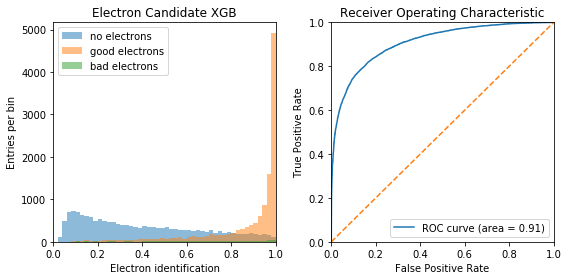

<IPython.core.display.Javascript object>

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

y_pred = model_e.predict_proba(X_test).T[1]
fpr, tpr, _ = roc_curve(y_test["train_label"], y_pred)
roc_auc = auc(fpr, tpr)

ax[0].hist(
    y_pred[y_test["train_label"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="no electrons",
    density=False,
)
ax[0].hist(
    y_pred[(y_test["train_label"] == 1) & (y_test["train_weight"] > 2)],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="good electrons",
    density=False,
)
ax[0].hist(
    y_pred[(y_test["train_label"] == 1) & (y_test["train_weight"] < 2)],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="bad electrons",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Electron identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("Electron Candidate XGB")

ax[1].plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

fig.tight_layout()
fig.savefig(output_dir + "e_bdt_test.pdf")

#### Other daughters training

In [31]:
train_q = "preselect & ~e_candidate"
X_train = []
X_test = []
y_train = []
y_test = []
for k in ["train"]:
    X = sample_info[k]["daughters"].query(train_q)[col_train_other]
    Y = sample_info[k]["daughters"].query(train_q)[["train_label", "train_weight"]]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, Y, test_size=test_size, random_state=seed
    )
    X_train.append(X_tr)
    X_test.append(X_te)
    y_train.append(y_tr)
    y_test.append(y_te)

# Merge our two samples
X_train = pd.concat(X_train).reset_index(drop=True)
y_train = pd.concat(y_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
y_test = pd.concat(y_test).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [32]:
# fit model on training data
if retrain:
    model_d = XGBClassifier(max_depth=6)
    model_d.fit(X_train, y_train["train_label"], sample_weight=y_train["train_weight"])
    dump(model_d, model_dir + "model_d.pckl")
else:
    model_d = load(model_dir + "model_d.pckl")

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


<IPython.core.display.Javascript object>

In [33]:
# make predictions for test data
y_pred = model_d.predict(X_test)
target_names = ["proton, pion, ...", "muon, overlay, photon"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_d.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_d.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_other)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

                       precision    recall  f1-score   support

    proton, pion, ...       0.54      0.70      0.61     25623
muon, overlay, photon       0.85      0.73      0.79     56936

             accuracy                           0.72     82559
            macro avg       0.69      0.72      0.70     82559
         weighted avg       0.75      0.72      0.73     82559

Test accuracy: 72.40%
Train accuracy: 72.86%

1. feature trk_llr_pid_score_v (0.472127)
2. feature trk_distance_v (0.225273)
3. feature pfp_generation_v (0.091812)
4. feature trk_score_v (0.089908)
5. feature pfp_trk_daughters_v (0.040505)
6. feature hits_per_tklen_v (0.032367)
7. feature pfp_shr_daughters_v (0.025814)
8. feature trk_len_v (0.022194)


<IPython.core.display.Javascript object>

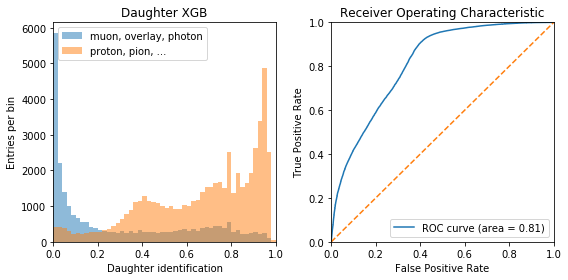

<IPython.core.display.Javascript object>

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

y_pred = model_d.predict_proba(X_test).T[1]
fpr, tpr, _ = roc_curve(y_test["train_label"], y_pred)
roc_auc = auc(fpr, tpr)

ax[0].hist(
    y_pred[y_test["train_label"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="muon, overlay, photon",
    density=False,
)
ax[0].hist(
    y_pred[y_test["train_label"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="proton, pion, ...",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Daughter identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("Daughter XGB")

ax[1].plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

fig.tight_layout()
fig.savefig(output_dir + "daughter_bdt_test.pdf")

#### Apply models on the samples!

In [35]:
%time
# add the columns for each daughter (all samples)
for k, v in sample_info.items():
    v["daughters"]["score"] = -1
    mask_e_cand = v["daughters"].eval("preselect & e_candidate")
    v["daughters"].loc[mask_e_cand, "score"] = model_e.predict_proba(
        v["daughters"][col_train_electron][mask_e_cand]
    ).T[1]
    mask_d = v["daughters"].eval("preselect & ~e_candidate")
    v["daughters"].loc[mask_d, "score"] = model_d.predict_proba(
        v["daughters"][col_train_other][mask_d]
    ).T[1]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


<IPython.core.display.Javascript object>

#### Train on the events

In [36]:
%%time
# First we need to add some columns:
for k, v in sample_info.items():    
    print(k)
    grouper = 'event'
    if k=='train':
        grouper = ['event', 'sample']
    
    mask_e = v["daughters"].eval("preselect & e_candidate & n_pfps>1")
    v["daughters"]["score_other_max"] = -1
    
    v["daughters"].loc[mask_e, "score_other_max"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby(grouper, sort=False)
        .max()
        .values
    )
    v["daughters"]["score_other_mean"] = -1
    v["daughters"].loc[mask_e, "score_other_mean"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby(grouper, sort=False)
        .mean()
        .values
    )
    v["daughters"]["score_other_min"] = -1
    v["daughters"].loc[mask_e, "score_other_min"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby(grouper, sort=False)
        .min()
        .values
    )

nu
nue
on
off
dirt
train
CPU times: user 1.75 s, sys: 176 ms, total: 1.93 s
Wall time: 1.93 s


<IPython.core.display.Javascript object>

In [37]:
train_q = "preselect & e_candidate"

X_train = []
X_test = []
y_train = []
y_test = []
for k in ["train"]:
    X = sample_info[k]["daughters"].query(train_q)[col_train_event]
    Y = sample_info[k]["daughters"].query(train_q)[["nueccinc", "train_weight"]]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, Y, test_size=test_size, random_state=seed
    )
    X_train.append(X_tr)
    X_test.append(X_te)
    y_train.append(y_tr)
    y_test.append(y_te)

# Merge our two samples
X_train = pd.concat(X_train).reset_index(drop=True)
y_train = pd.concat(y_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
y_test = pd.concat(y_test).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [38]:
# fit model on training data\
if retrain:
    model_event = XGBClassifier(max_depth=6)
    model_event.fit(X_train, y_train["nueccinc"], sample_weight=y_train["train_weight"])
    dump(model_event, model_dir + "model_event.pckl")
else:
    model_event = load(model_dir + "model_event.pckl")

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


<IPython.core.display.Javascript object>

In [39]:
# make predictions for test data
y_pred = model_event.predict(X_test)
target_names = ["nueccinc", "background events"]
print(classification_report(y_test["nueccinc"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["nueccinc"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_event.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["nueccinc"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_event.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_event)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

                   precision    recall  f1-score   support

         nueccinc       0.89      0.75      0.81     15793
background events       0.77      0.90      0.83     14531

         accuracy                           0.82     30324
        macro avg       0.83      0.83      0.82     30324
     weighted avg       0.83      0.82      0.82     30324

Test accuracy: 82.20%
Train accuracy: 83.89%

1. feature score (0.585741)
2. feature score_other_min (0.154211)
3. feature contained_fraction (0.066728)
4. feature n_showers (0.055510)
5. feature hits_ratio (0.043662)
6. feature n_pfp_farvtx (0.035623)
7. feature score_other_mean (0.031903)
8. feature score_other_max (0.026621)


<IPython.core.display.Javascript object>

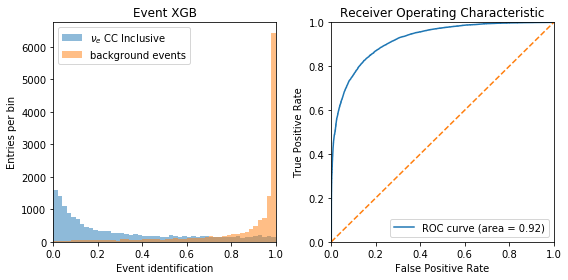

<IPython.core.display.Javascript object>

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

y_pred = model_event.predict_proba(X_test).T[1]
fpr, tpr, _ = roc_curve(y_test["nueccinc"], y_pred)
roc_auc = auc(fpr, tpr)

ax[0].hist(
    y_pred[y_test["nueccinc"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label=r"$\nu_e$ CC Inclusive",
    density=False,
)
ax[0].hist(
    y_pred[y_test["nueccinc"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="background events",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Event identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("Event XGB")

ax[1].plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

fig.tight_layout()
fig.savefig(output_dir + "event_bdt_test.pdf")

In [41]:
%time
# add the columns for each daughter (all samples)
for k, v in sample_info.items():
    print(k)
    v["daughters"]["score_event"] = -1
    mask_e_cand = v["daughters"].eval("preselect & e_candidate")
    v["daughters"].loc[mask_e_cand, "score_event"] = model_event.predict_proba(
        v["daughters"][col_train_event][mask_e_cand]
    ).T[1]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs
nu
nue
on
off
dirt
train


<IPython.core.display.Javascript object>

In [44]:
query_select = "e_candidate & preselect & score_event>0.976"
# Passing rate selection
for k, v in sample_info.items():
    grouper = "event"
    if k == "train":
        grouper = ["event", "sample"]
    v["daughters"]["select"] = v["daughters"].eval(query_select)
    v["daughters"]["select"] = (
        v["daughters"]["select"].groupby(grouper, sort=False).transform(max)
    )

    pass_rate = sum(v["daughters"].eval("(e_candidate & select)")) / v["numentries"]
    print(k, "\t{:.4f}%".format(pass_rate * 100))

# Passing rate signal, weights applied!
pass_rate = sum(
    sample_info["nue"]["daughters"].eval("(e_candidate & select)*weightSpline*nueccinc")
) / sum(sample_info["nue"]["mc"]["weightSpline"] * sample_info["nue"]["mc"]["nueccinc"])
print("nue signal passing the selection \t{:.2f}%".format(pass_rate * 100))
nue_pass = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*weightSpline*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    * pot_scale
)
print(
    "nue Intrinsic signal passing: {0:0.3f} per {1:0.2g} POT".format(
        nue_pass, pot_target
    )
)
lee_pass = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*leeweight*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    * pot_scale
)
print("nue LEE signal passing: {0:0.3f} per {1:0.2g} POT".format(lee_pass, pot_target))

## Calculate the purity:
purity_denom = (
    sum(sample_info["nu"]["daughters"].eval("(e_candidate & select)*weightSpline"))
    * sample_info["nu"]["scaling"]
)
purity_denom += (
    sum(sample_info["dirt"]["daughters"].eval("(e_candidate & select)*weightSpline"))
    * sample_info["dirt"]["scaling"]
)
purity_denom += (
    sum(sample_info["off"]["daughters"].eval("(e_candidate & select)"))
    * sample_info["off"]["scaling"]
)

purity_mc = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*weightSpline*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    / purity_denom
)
purity_data = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*weightSpline*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    / sum(sample_info["on"]["daughters"].eval("(e_candidate & select)"))
)
print(
    "Purity MC: {:.1f}%\nData/MC-ratio: {:.2f}\n".format(
        purity_mc * 100,
        sum(sample_info["on"]["daughters"].eval("(e_candidate & select)"))
        / purity_denom,
    )
)

nu 	0.0639%
nue 	16.7941%
on 	0.0102%
off 	0.0032%
dirt 	0.0010%
train 	2.0868%
nue signal passing the selection 	19.47%
nue Intrinsic signal passing: 121.505 per 4.3e+20 POT
nue LEE signal passing: 4.500 per 4.3e+20 POT
Purity MC: 46.6%
Data/MC-ratio: 0.65



<IPython.core.display.Javascript object>

In [45]:
np.savetxt(
    output_dir + "events_run{}.txt".format(run),
    sample_info["on"]["daughters"].query("(e_candidate & select)")[
        ["run", "sub", "evt"]
    ],
    fmt="%u",
)
sample_info["on"]["daughters"].query("(e_candidate & select)")

,,run,sub,evt,topological_score,n_pfps,n_showers,n_tracks,reco_nu_vtx_sce_x,reco_nu_vtx_sce_y,reco_nu_vtx_sce_z,reco_nu_vtx_x,reco_nu_vtx_y,reco_nu_vtx_z,crtveto,crthitpe,slclustfrac,hits_ratio,nu_flashmatch_score,selected,category,nslice,CosmicIP,n_tracks_contained,contained_sps_ratio,contained_fraction,slpdg,SliceCaloEnergy2,NeutrinoEnergy2,trk_score_v,trk_distance_v,trk_theta_v,trk_phi_v,trk_len_v,trk_pid_chipr_v,trk_pid_chimu_v,trk_pid_chipr_v_v,trk_pid_chimu_v_v,trk_pid_chipr_u_v,trk_pid_chimu_u_v,trk_llr_pid_u_v,trk_llr_pid_v_v,trk_llr_pid_y_v,trk_llr_pid_v,trk_llr_pid_score_v,trk_mcs_muon_mom_v,trk_calo_energy_y_v,trk_sce_end_x_v,trk_sce_end_y_v,trk_sce_end_z_v,trk_sce_start_x_v,trk_sce_start_y_v,trk_sce_start_z_v,shr_energy_y_v,shr_openangle_v,shr_tkfit_start_x_v,shr_tkfit_start_y_v,shr_tkfit_start_z_v,shr_tkfit_theta_v,shr_tkfit_phi_v,shr_tkfit_dedx_u_v,shr_tkfit_dedx_v_v,shr_tkfit_dedx_y_v,shr_tkfit_gap10_dedx_u_v,shr_tkfit_gap10_dedx_v_v,shr_tkfit_gap10_dedx_y_v,shr_tkfit_nhits_v,shr_tkfit_dedx_nhits_u_v,shr_tkfit_dedx_nhits_v_v,shr_tkfit_dedx_nhits_y_v,shr_moliere_avg_v,shr_moliere_rms_v,pfnplanehits_U,pfnplanehits_V,pfnplanehits_Y,pfpplanesubclusters_U,pfpplanesubclusters_V,pfpplanesubclusters_Y,pfpplanesubhitfracmax_U,pfpplanesubhitfracmax_V,pfpplanesubhitfracmax_Y,pfnhits,pfp_generation_v,pfp_trk_daughters_v,pfp_shr_daughters_v,trk_min_cos,reco_fid_vol,all_start_contained,all_end_contained,n_pfpvtx,n_pfp_farvtx,shr_dist_v,e_candidate,shr_tkfit_dedx_wm_v,trk_pid_chimu_wm_v,trk_pid_chipr_wm_v,hits_per_tklen_v,shr_tkfit_ratiogap_dedx_y_v,shr_subclusters_v,shr_tkfit_hitratio_v,trk_muon_hypothesis_ratio_v,mu_candidate,mu_candidate_event,_closestNuCosmicDist,preselect,score,score_other_max,score_other_mean,score_other_min,score_event,select
event,daughter,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10862,0,5229,65,3279,0.999393,3,1,2,248.553635,17.624880,594.095520,249.709274,16.037838,594.098267,0,0.0,0.692854,0.000000,3.834553,0,0,1,17.396509,0,0.802412,0.000000,12,254.954819,1116.291748,0.001252,1.106554,0.608321,-2.456727,143.528030,140.956665,28.673487,300.000000,30.803513,178.213882,21.511080,373.878204,133.397003,177.669434,684.944641,0.907707,0.435133,1799.687500,191.850998,-26.340033,691.286560,248.018616,17.305868,595.019470,708.404175,-4.913265e+14,246.407837,12.643660,599.950012,0.497432,-2.758191,2.040803,7.425882,2.714557,4.988124e+00,22.656788,3.022426,191,4,3,8,3.709489,255.526062,504,173,510,11,8,13,0.0,0.0,0.0,1187,2,0,0,0.323619,True,True,False,3.0,0.0,7.527474,True,3.477154,25.942772,179.955936,8.270162,0.898138,32,0.160910,0.000242,False,False,999,True,0.980485,0.951872,0.873112,0.794352,0.984284,True
47695,0,5557,151,7582,0.431951,3,1,2,238.940948,-83.391891,254.805603,239.978821,-75.611633,254.722214,0,0.0,0.822188,0.432532,2.606473,1,0,1,60.411995,2,0.844262,1.000000,12,139.088867,719.329468,0.147410,0.105060,2.755934,-0.514827,23.667891,107.486198,15.594870,83.113724,6.363892,231.809296,26.155333,56.668003,35.212997,123.004021,214.885010,0.722715,0.157334,254.622940,246.595032,-88.817528,233.172363,238.830887,-83.378967,254.809753,174.700592,-1.744430e-11,239.890457,-75.504257,254.949997,2.785556,-0.562202,2.827220,3.332724,2.652281,2.873374e+00,3.116784,2.661675,130,5,9,13,4.449938,163.553680,53,49,132,1,1,2,1.0,1.0,0.0,234,2,0,0,-0.769024,True,True,True,3.0,0.0,0.266876,True,2.911491,16.053787,130.541211,9.886813,0.996471,4,0.555556,0.000618,False,False,999,True,0.963199,0.949803,0.932779,0.915756,0.997015,True
49306,0,5729,121,6086,0.987029,4,1,2,84.136681,-12.268237,657.436829,86.737610,-12.436200,657.349670,0,0.0,0.682499,0.920671,12.570055,1,0,1,73.662186,2,1.000000,1.000000,12,247.477631,1210.190918,0.001512,0.249804,0.754368,2.163889,75.358177,131.254471,34.965889,163.555771,18.754660,300.000000,38.139103,168.902863,333.855957,307.515381,810.274170,0.921827,0.285062,6512.161621,59.315952,33.255669,700.520386,84.143326,-1

<IPython.core.display.Javascript object>

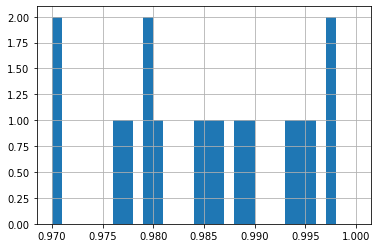

<IPython.core.display.Javascript object>

In [43]:
sample_info["on"]["daughters"].query("(e_candidate & select)")["score_event"].hist(
    range=(0.97, 1), bins=30
)

In [46]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")["true_vtx_distance"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[0].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")["true_vtx_distance_check"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx_sce - reco_nu_vtx|",
    alpha=0.7,
)
ax[0].set_xlabel("Neutrino vertex distance [cm]")
ax[0].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[0].set_title("Run3 Overlay", loc="right")
ax[0].legend()

ax[1].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")
    .eval("true_nu_vtx_x+@x_sce_magic-reco_nu_vtx_sce_x"),
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[1].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")
    .eval("true_nu_vtx_sce_x-reco_nu_vtx_x"),
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx_sce - reco_nu_vtx|",
    alpha=0.7,
)
ax[1].set_xlabel("Neutrino vertex distance x-coordinate [cm]")
ax[1].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[1].set_title("Run3 Overlay", loc="right")
ax[1].set_ylim(0, ax[1].get_ylim()[1] * 1.25)
ax[1].legend()

fig.tight_layout()
fig.savefig(output_dir + "vtx_distance.pdf")

CPU times: user 1.1 s, sys: 772 ms, total: 1.87 s
Wall time: 4.24 s


<IPython.core.display.Javascript object>

### Plots

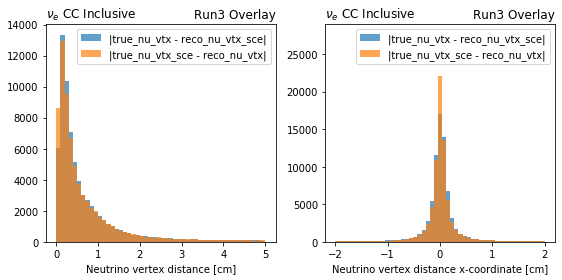

<IPython.core.display.Javascript object>

In [46]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")["true_vtx_distance"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[0].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")["true_vtx_distance_check"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx_sce - reco_nu_vtx|",
    alpha=0.7,
)
ax[0].set_xlabel("Neutrino vertex distance [cm]")
ax[0].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[0].set_title("Run3 Overlay", loc="right")
ax[0].legend()

ax[1].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")
    .eval("true_nu_vtx_x+@x_sce_magic-reco_nu_vtx_sce_x"),
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[1].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")
    .eval("true_nu_vtx_sce_x-reco_nu_vtx_x"),
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx_sce - reco_nu_vtx|",
    alpha=0.7,
)
ax[1].set_xlabel("Neutrino vertex distance x-coordinate [cm]")
ax[1].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[1].set_title("Run3 Overlay", loc="right")
ax[1].set_ylim(0, ax[1].get_ylim()[1] * 1.25)
ax[1].legend()

fig.tight_layout()
fig.savefig(output_dir + "vtx_distance.pdf")

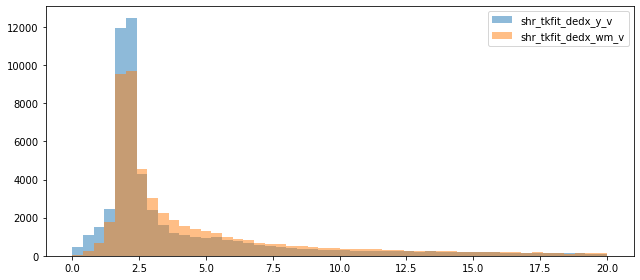

<IPython.core.display.Javascript object>

In [47]:
fig, ax = plt.subplots(ncols=1, figsize=(9, 4))

data = sample_info["nue"]["daughters"].query("e_candidate & abs(backtracked_pdg==11)")[
    ["shr_tkfit_dedx_y_v", "shr_tkfit_dedx_wm_v"]
]

for col in data.columns:
    ax.hist(data[col], bins=50, range=(0, 20), label=col, alpha=0.5)
ax.legend()

fig.tight_layout()
fig.savefig(output_dir + "e_preselection_dedx.pdf")

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/numpy/linalg/linalg.py:2512: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


ValueError: supplied range of [0.000562625820748508, inf] is not finite

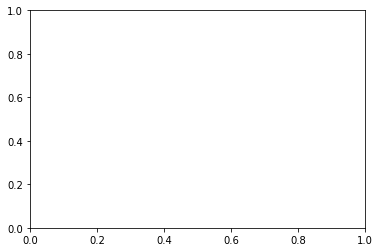

<IPython.core.display.Javascript object>

In [48]:
data = sample_info["nue"]["daughters"][
    [
        "shr_tkfit_start_x_v",
        "shr_tkfit_start_y_v",
        "shr_tkfit_start_z_v",
        "reco_nu_vtx_x",
        "reco_nu_vtx_y",
        "reco_nu_vtx_z",
    ]
].values.T
sample_info["nue"]["daughters"]["shr_dist_v"] = np.linalg.norm(
    data[0:3] - data[3:6], axis=0
)


sample_info["nue"]["daughters"]["shr_dist_v"].hist()